# AIN423 Data Intensive Applications DSCP Project : Detecting Sleep Stage Using Data-Driven Methods 

## Group Badge : Cinai Şebeke 
### Erdem Korhan ERDEM 21992924  -   Kazım Halil KESMÜK 2200765031

Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler pandas numpy tsflex

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../src/")

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import tsflex

from tqdm.auto import tqdm

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data

Commands to download and extract the data;
```sh
mkdir data
wget https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip -P data
# Extrac all data
unzip data/sleep-edf-database-expanded-1.0.0.zip -d data
```

The Sleep EDF Expanded dataset is a widely-used resource in sleep research, particularly in the field of polysomnography (PSG). Polysomnography is a comprehensive recording of the physiological changes that occur during sleep. This dataset consists of recordings of sleep patterns from various individuals, making it valuable for studying sleep architecture, disorders, and related phenomena.

The dataset contains polysomnographic recordings, which typically include EEG (electroencephalogram), EOG (electrooculogram), EMG (electromyogram), ECG (electrocardiogram), and other physiological signals. These signals provide insight into brain activity, eye movements, muscle tone, and cardiac activity during sleep.

Each recording is accompanied by annotations indicating the different sleep stages. These annotations are crucial for training and evaluating algorithms designed for automatic sleep stage classification.

# Data loading

## Some EDF loading funcs

In [6]:
from src.data import load_signals, load_annotations, annotation_to_30s_labels

## Load some data

In [7]:
data_folder = "./sleep-edf-database-expanded-1.0.0/"

os.listdir(data_folder)

['RECORDS',
 'RECORDS-v1',
 'SC-subjects.xls',
 'SHA256SUMS.txt',
 'sleep-cassette',
 'sleep-telemetry',
 'ST-subjects.xls']

In [8]:
os.listdir(data_folder + "sleep-cassette")[:10]

['SC4001E0-PSG.edf',
 'SC4001EC-Hypnogram.edf',
 'SC4002E0-PSG.edf',
 'SC4002EC-Hypnogram.edf',
 'SC4011E0-PSG.edf',
 'SC4011EH-Hypnogram.edf',
 'SC4012E0-PSG.edf',
 'SC4012EC-Hypnogram.edf',
 'SC4021E0-PSG.edf',
 'SC4021EH-Hypnogram.edf']

In [9]:
len(os.listdir(data_folder + "sleep-cassette"))

306

=> In total 306 files (153 PSG files - 153 hypnogram files) => 7.1 GB

In [10]:
dfs = []
sub_folder = "sleep-cassette"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder

# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files

,psg_file,label_file,subfolder,patient_id
0,SC4001E0-PSG.edf,SC4001EC-Hypnogram.edf,sleep-cassette,SC400
1,SC4002E0-PSG.edf,SC4002EC-Hypnogram.edf,sleep-cassette,SC400
2,SC4011E0-PSG.edf,SC4011EH-Hypnogram.edf,sleep-cassette,SC401
3,SC4012E0-PSG.edf,SC4012EC-Hypnogram.edf,sleep-cassette,SC401
4,SC4021E0-PSG.edf,SC4021EH-Hypnogram.edf,sleep-cassette,SC402
...,...,...,...,...
148,SC4802G0-PSG.edf,SC4802GV-Hypnogram.edf,sleep-cassette,SC480
149,SC4811G0-PSG.edf,SC4811GG-Hypnogram.edf,sleep-cassette,SC481
150,SC4812G0-PSG.edf,SC4812GV-Hypnogram.edf,sleep-cassette,SC481
151,SC4821G0-PSG.edf,SC4821GC-Hypnogram.edf,sleep-cassette,SC482


In [11]:
paper_patients = [
    "SC400",
    "SC401",
    "SC402",
    "SC403",
    "SC404",
    "SC405",
    "SC406",
    "SC407",
    "SC408",
    "SC409",
    "SC410",
    "SC411",
    "SC412",
    "SC413",
    "SC414",
    "SC415",
    "SC416",
    "SC417",
    "SC418",
    "SC419",
]

In [12]:
df_files_paper = df_files[df_files.patient_id.isin(paper_patients)]
df_files_paper.psg_file.nunique()

39

In [13]:
df_files_paper.patient_id.nunique()

20

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [14]:
df_files_other = df_files[~df_files.patient_id.isin(paper_patients)]
df_files_other.psg_file.nunique()

114

In [15]:
df_files_other.patient_id.nunique()

58

In [16]:
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(
        data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
        only_info=True,
    )
    for s, f in zip(sig, freq):
        if (s, f) in signal_dict.keys():
            signal_dict[(s, f)].append(idx)
        else:
            signal_dict[(s, f)] = [idx]

# Displays (sig, freq) #recordings
[(k, len(v)) for k, v in signal_dict.items()]

[(('EEG Fpz-Cz', 100.0), 153),
 (('EEG Pz-Oz', 100.0), 153),
 (('EOG horizontal', 100.0), 153),
 (('Resp oro-nasal', 1.0), 153),
 (('EMG submental', 1.0), 153),
 (('Temp rectal', 1.0), 153),
 (('Event marker', 1.0), 153)]

In [17]:
common_signals = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",  # All have the same sampling rate (100 Hz)
    "EMG submental",  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

In [18]:
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
)

C:\Users\W11\Desktop\code\src\data.py:68: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df["onset"] = start_time + pd.TimedeltaIndex(df["onset"], unit="s")
C:\Users\W11\Desktop\code\src\data.py:75: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df["end"] = df.index + pd.TimedeltaIndex(df["duration"], unit="s")


In [19]:
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]

# EDA + pipeline (for 1 patient)

In [20]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[],
            y=[],
            name=s.name,
            line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[],
        y=[],
        name="Hypnogram",
        line_width=1.5,
        line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_dark",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8041)

C:\Users\W11\Desktop\code\src\data.py:106: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



## Process the signals

The signal processing code provided utilizes a Butterworth bandpass filter to preprocess EEG (electroencephalogram) and EOG (electrooculogram) signals for sleep stage detection. The butter_bandpass_filter function is defined to implement the bandpass filtering operation. It takes as input the signal to be filtered (sig), the lower and upper cutoff frequencies (lowcut and highcut, respectively), the sampling frequency (fs), and optionally, the filter order (order). Inside the function, the cutoff frequencies are normalized with respect to the Nyquist frequency, which is half of the sampling frequency. Then, a Butterworth bandpass filter is designed using these normalized cutoff frequencies and, if provided, the filter order. Finally, the designed filter is applied to the input signal using the lfilter function from SciPy's signal module.

In [21]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


# def clipper(sig, min_q=0, max_q=1):
#     return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
]

In [22]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: total: 312 ms
Wall time: 338 ms


In [23]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.show_dash(port=8041)

## Extract the features

The following codeblock is presented for extracting features from time series data using the tsfresh library, which specializes in transforming raw data into structured features for machine learning models. This setup is broadly divided into three categories: 
fft_aggregated, fourier_entropy, and binned_entropy, each serving a unique purpose in feature extraction.

Within the 
fft_aggregated section, we aim to grasp the fundamental aspects of the frequency domain by calculating the spectrum's centroid, variance, skewness, and kurtosis through the Fast Fourier Transform (FFT) of the time series. This method helps in understanding the distribution and concentration of the signal’s frequency components.

Moving on to fourier_entropy and binned_entropy, these sections delve into measuring the randomness or unpredictability in the time series from two different perspectives. fourier_entropy
calculates the entropy over the frequency spectrum created by FFT, applying various bin sizes to capture the complexity at different resolutions. On the other hand, binned_entropy focuses more directly on the time series itself, segmenting its amplitude into specified bin sizes to evaluate the distribution's irregularity.

In [24]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [25]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc

In [26]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)

In [27]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m,EEG Fpz-Cz__TotalAbsPow__w=1m30s,EEG Fpz-Cz__TotalAbsPow__w=30s,EEG Fpz-Cz__alpha__w=1m,EEG Fpz-Cz__alpha__w=1m30s,EEG Fpz-Cz__alpha__w=30s,EEG Fpz-Cz__beta__w=1m,EEG Fpz-Cz__beta__w=1m30s,EEG Fpz-Cz__beta__w=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m,...,EOG horizontal__skew__w=30s,EOG horizontal__std__w=1m,EOG horizontal__std__w=1m30s,EOG horizontal__std__w=30s,EOG horizontal__theta__w=1m,EOG horizontal__theta__w=1m30s,EOG horizontal__theta__w=30s,EOG horizontal__wrapped_higuchi_fd__w=1m,EOG horizontal__wrapped_higuchi_fd__w=1m30s,EOG horizontal__wrapped_higuchi_fd__w=30s
1989-04-24 16:13:30,NaN,NaN,552.556158,NaN,NaN,0.011966,NaN,NaN,0.01293,NaN,...,0.173134,NaN,NaN,71.403606,NaN,NaN,0.031219,NaN,NaN,1.257986
1989-04-24 16:14:00,410.013414,NaN,296.813297,0.018171,NaN,0.028862,0.024353,NaN,0.046444,1.667629,...,0.203721,73.886409,NaN,76.288450,0.042809,NaN,0.058202,1.488313,NaN,1.641231
1989-04-24 16:14:30,284.113885,347.419726,358.240748,0.032559,0.0239,0.032287,0.03873,0.027223,0.027552,1.564244,...,-0.279640,70.765891,70.979105,64.774158,0.032964,0.034947,0.025595,1.607514,1.512376,1.563791
1989-04-24 16:15:00,206.055516,230.349632,187.837507,0.056282,0.041142,0.074854,0.03516,0.036783,0.028251,1.431736,...,0.029593,47.508646,58.691484,17.845006,0.064335,0.044394,0.100081,1.660663,1.652097,1.830498
1989-04-24 16:15:30,177.742607,176.336873,173.517873,0.068842,0.063116,0.059463,0.027978,0.034582,0.027121,1.376963,...,-0.439511,16.211393,39.671042,14.390960,0.10672,0.089847,0.111054,1.828444,1.701058,1.827002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989-04-25 14:15:30,212.469296,307.817513,255.230551,0.036642,0.025157,0.030919,0.047035,0.031875,0.034681,1.535747,...,0.067072,56.496391,64.824067,62.682500,0.058822,0.055937,0.045841,1.569018,1.608524,1.519734
1989-04-25 14:16:00,204.06735,195.455113,162.540943,0.035044,0.036785,0.035758,0.040611,0.047695,0.051777,1.621815,...,0.001826,60.120669,56.813446,57.442227,0.045717,0.052746,0.053498,1.611479,1.612943,1.687073
1989-04-25 14:16:30,203.696881,230.956086,287.986357,0.036019,0.031562,0.026256,0.047291,0.039144,0.034697,1.413289,...,-0.010830,66.556921,65.291381,74.564612,0.059213,0.049297,0.064801,1.699283,1.651181,1.711871
1989-04-25 14:17:00,217.303883,204.767336,184.806999,0.037448,0.038002,0.047466,0.042533,0.044301,0.047973,1.410208,...,-0.041717,67.617997,64.404993,59.867784,0.056196,0.055605,0.046247,1.638321,1.653585,1.516722


# Pipeline for all patients

Following codeblock applies the signal processing pipeline for all the patients in the Sleep-EDF dataset and saves the results into a .parquet file. The total process takes about 6-7 hours, so it is left as comment. For test purposes, please do not forget to uncomment it.

In [30]:
"""
from tqdm.auto import tqdm

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(
    zip(df_files.subfolder, df_files.psg_file, df_files.label_file)
):
    file_folder = data_folder + sub_folder + "/"
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

df_feats.to_parquet("sleep-edf__cassette_features_ALL__90s.parquet")

"""

'\nfrom tqdm.auto import tqdm\n\ndf_feats = []\nfor sub_folder, psg_file, hypnogram_file in tqdm(\n    zip(df_files.subfolder, df_files.psg_file, df_files.label_file)\n):\n    file_folder = data_folder + sub_folder + "/"\n    # Load the data, process the data and extract features\n    data = load_signals(file_folder + psg_file)\n    data_processed = process_pipe.process(data)\n    df_feat = feature_collection.calculate(\n        data_processed, return_df=True, window_idx="begin"\n    ).astype("float32")\n    # Add the labels (and reduce features to only data for which we have labels)\n    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)\n    annotations = annotation_to_30s_labels(annotations)\n    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)\n    # Add the file name & folder\n    df_feat["psg_file"] = psg_file\n    df_feat["patient_id"] = psg_file[:5]\n    # Collect the dataframes\n    df_feats += [df_feat]\n\ndf_feats = pd

## Load data

In [31]:
import pyarrow
import fastparquet

In [32]:
df_feats = pd.read_parquet("sleep-edf__cassette_features_ALL__90s.parquet")
df_feats.shape

(416271, 366)

In [33]:
df_feats["label"].value_counts()

label
Sleep stage W    285286
Sleep stage 2     69132
Sleep stage R     25835
Sleep stage 1     21521
Sleep stage 3      8793
Sleep stage 4      4246
Sleep stage ?      1330
Movement time       128
Name: count, dtype: int64

In [34]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [35]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to patient_id
dtypes: float32(363), object(3)
memory usage: 589.1+ MB


The code provided is designed to process a collection of features stored in a DataFrame, specifically targeting features derived from EEG (Electroencephalogram) and other similar signals. The primary task is filtering out EEG-specific features based on predefined frequency bands (alpha, beta, sdelta, fdelta, sigma, theta) and then performing arithmetic operations to compute new variables, which are essentially ratios and sums of the spectral powers within these bands.

By iterating over EEG signals, the code identifies related features within the specified bands, and for each, calculates combined metrics (like the sum of sdelta and fdelta powers) and several ratios (such as alpha/theta or delta/beta). These new metrics are believed to offer insights into the underlying physiological states or brain activities during the time windows from which the original features were extracted.

Finally, these newly computed features are added back into the DataFrame, expanding it with additional columns that represent these spectral metrics across different temporal windows for each EEG signal examined. The process enriches the dataset with more nuanced information, potentially enhancing the analysis or the predictive capacity of models built using this data.

In [36]:
eeg_signals = [d for d in common_signals if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [
        c
        for c in df_feats.columns
        if c.startswith(eeg_sig) and c.split("__")[1] in bands
    ]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = (
            df_feats["__".join([eeg_sig, "sdelta", window])]
            + df_feats["__".join([eeg_sig, "fdelta", window])]
        )
        fdelta_theta = (
            df_feats["__".join([eeg_sig, "fdelta", window])]
            + df_feats["__".join([eeg_sig, "theta", window])]
        )
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype(
            "float32"
        )

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype(
            "float32"
        )
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype(
            "float32"
        )
df_feats.shape

(416271, 396)

In [37]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

The code aims to enrich the features of a DataFrame (df_feats) containing time-series data by incorporating information from adjacent time windows around each 30-second sample. It categorizes features into groups based on their time windows—30 seconds, 1 minute, and 1 minute 30 seconds. The approach involves iterating through the data subset by subset, each corresponding to a unique PSG file.

For each subset, it shifts the features to simulate 'looking into' the time surrounding each epoch - both the preceding and the following minutes. By shifting and merging these features, each 30-second sample in the subset is appended with data from the minute before and after, offering a more comprehensive view of the data's temporal context.

This procedure effectively augments the DataFrame with a richer set of features for each sample, likely improving the depth of analysis or the accuracy of predictive models that utilize this dataset. Finally, these enhanced subsets are concatenated to reform the expanded dataset, now equipped with a broader temporal feature set for each epoch.

In [38]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]
    
    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(2).add_suffix("_shift=1m"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),
        left_index=True,
        right_index=True,
    )
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 0 131


(416271, 920)

In [39]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 416271 entries, 1989-04-24 16:13:00 to 1991-09-27 14:24:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m to EEG Pz-Oz__delta/theta__w=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 1.4+ GB


In [40]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[
    df_feats["label"] != "Sleep stage ?"
]  # Label that is given when recording is done / end of the night

In [41]:
df_feats_paper = df_feats[df_feats.psg_file.isin(df_files_paper.psg_file)]
df_feats_paper.shape

(106377, 920)

In [42]:
def get_repeat_length(val, arr):
    assert arr[0] == val
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats_paper["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_paper = pd.concat(dfs)
del dfs

In [43]:
def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1


dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats_trimmed_all = pd.concat(dfs)
del dfs

Prepare training data for SleepEDF-20

In [44]:
# Subset of data that does not contain the SC-EDF-20 patients
df_feats_trimmed = df_feats_trimmed_all[
    ~df_feats_trimmed_all.psg_file.isin(df_feats_trimmed_paper.psg_file.unique())
]
df_feats_trimmed.shape

(152938, 920)

In [45]:
any(
    [
        psg_file in df_feats_trimmed_paper.psg_file.unique()
        for psg_file in df_feats_trimmed
    ]
)

False

In [46]:
# Label stats for the SC-EDF-78 \ SC-EDF20 data
df_feats_trimmed["label"].value_counts()

label
Sleep stage W    57435
Sleep stage 2    51333
Sleep stage 1    18716
Sleep stage R    18118
Sleep stage 3     7336
Name: count, dtype: int64

In [47]:
# Label stats for the SC-EDF-20 data
print(len(df_feats_trimmed_paper))
df_feats_trimmed_paper["label"].value_counts()

42230


label
Sleep stage 2    17799
Sleep stage W     8207
Sleep stage R     7717
Sleep stage 3     5703
Sleep stage 1     2804
Name: count, dtype: int64

Matches with the samples from other papers

In [48]:
# Label stats for the SC-EDF-78 data
print(len(df_feats_trimmed_all))
df_feats_trimmed_all["label"].value_counts()

195168


label
Sleep stage 2    69132
Sleep stage W    65642
Sleep stage R    25835
Sleep stage 1    21520
Sleep stage 3    13039
Name: count, dtype: int64

The trimmed wake value count now matches (roughly) the amount of the IITNet & DeepSleepNet paper

### Look into nan features

In [49]:
no_shift_cols = [c for c in df_feats_trimmed_all.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [50]:
normal_nan_mask = (df_feats_trimmed_all[no_shift_cols].isna().sum() / df_feats_trimmed_all.psg_file.nunique()).isin([0, 1, 2])
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EMG submental__wrapped_higuchi_fd__w=30s                        160
EMG submental__hjorth_complexity__w=30s                         160
EMG submental__fft_aggregated_{'aggtype': 'skew'}__w=30s        160
EMG submental__fft_aggregated_{'aggtype': 'kurtosis'}__w=30s    160
EMG submental__horth_mobility__w=30s                             57
EMG submental__fourier_entropy_{'bins': 60}__w=30s               57
EMG submental__fourier_entropy_{'bins': 5}__w=30s                57
EMG submental__fourier_entropy_{'bins': 3}__w=30s                57
EMG submental__fourier_entropy_{'bins': 30}__w=30s               57
EMG submental__fourier_entropy_{'bins': 2}__w=30s                57
EMG submental__fourier_entropy_{'bins': 10}__w=30s               57
EMG submental__fourier_entropy_{'bins': 100}__w=30s              57
EMG submental__fft_aggregated_{'aggtype': 'variance'}__w=30s     32
EMG submental__fft_aggregated_{'aggtype': 'centroid'}__w=30s     32
dtype: int64

In [51]:
df_feats_trimmed_all["psg_file"][df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1)].value_counts()

psg_file
SC4731E0-PSG.edf    64
SC4762E0-PSG.edf    48
SC4332F0-PSG.edf    44
SC4771G0-PSG.edf     4
Name: count, dtype: int64

In [52]:
df_feats_trimmed_all[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats_trimmed_all)

0.0008198065256599442

=> 0.082% of the feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values stem from artefacts in the EMG signal (mostly occuring at the beginning and/or end of the sleep period). These signal artefacts induce nan values as some features have the following error *"invalid value encountered in double_scalars"* (possibly due to division by zero).

**What to do with this?**  
For the sake of simplicity we will keep those feature vectors and just (simply) impute the nan values as
* only 0.082% of the feature vectors (i.e., samples) is affected -> will have minimal / no impact on results
* other work did not perform artefact removal -> we will include these samples as this allows a "fair" comparison

## EDA on labels

<Axes: xlabel='label'>

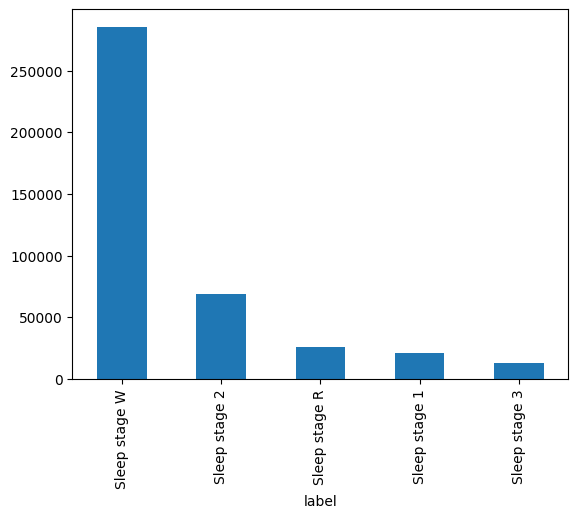

In [53]:
df_feats["label"].value_counts().plot(kind="bar")

<Axes: xlabel='label'>

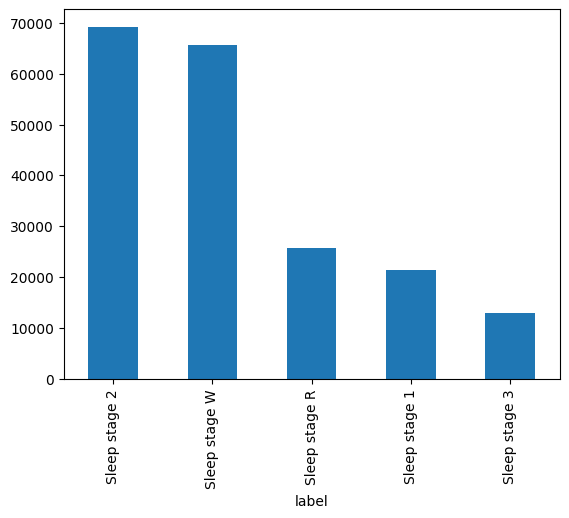

In [54]:
df_feats_trimmed_all["label"].value_counts().plot(kind="bar")

In [55]:
df_feats_trimmed_all["label"].value_counts()

label
Sleep stage 2    69132
Sleep stage W    65642
Sleep stage R    25835
Sleep stage 1    21520
Sleep stage 3    13039
Name: count, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [56]:
import math
import matplotlib.pyplot as plt

skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

# ML

After signal processing, feature extraction & selection process; here we apply the data driven methods to detect sleep stages. For this purpose, 4 models were selected: 
* A simple Logistic Regression classifier, selected to serve as a baseline.
* Random Forest classifier, selected to serve as a simple ensemble method.
* CatBoost, selected to serve as a more complex ensemble method.
* A more complex CNN architecture, inspired by TinySleepNet to serve as a Deep Learning method against traditional ML methods.

In [58]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [59]:
from src.visualizations import plot_linear_classification_coefs
from src.visualizations import plot_learning_curve
from src.visualizations import plot_confusion_matrix

## The simple, linear pipeline

In [60]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss ="log_loss",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

## Linear model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [61]:
### Fit the pipeline
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])

Pipeline(steps=[('impute', SimpleImputer()),
                ('scale',
                 QuantileTransformer(n_quantiles=100, random_state=0,
                                     subsample=200000)),
                ('linear_model',
                 SGDClassifier(average=True, class_weight='balanced',
                               loss='log_loss', n_jobs=5, random_state=0))])

In [62]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.5450092815372168
               precision    recall  f1-score   support

Sleep stage 1       0.55      0.52      0.54     18716
Sleep stage 2       0.85      0.83      0.84     51333
Sleep stage 3       0.63      0.88      0.73      7336
Sleep stage R       0.81      0.85      0.83     18118
Sleep stage W       0.95      0.92      0.93     57435

     accuracy                           0.83    152938
    macro avg       0.76      0.80      0.77    152938
 weighted avg       0.84      0.83      0.83    152938



In [63]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.4936452667145652
               precision    recall  f1-score   support

Sleep stage 1       0.50      0.44      0.47      2804
Sleep stage 2       0.91      0.87      0.89     17799
Sleep stage 3       0.83      0.93      0.88      5703
Sleep stage R       0.86      0.89      0.87      7717
Sleep stage W       0.91      0.92      0.91      8207

     accuracy                           0.86     42230
    macro avg       0.80      0.81      0.80     42230
 weighted avg       0.86      0.86      0.86     42230



In [64]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))

F1 macro:  0.8031895432755427
Bal. Acc:  0.7995517516161061
Kappa:     0.8120257038484586
Log loss : 0.4936452667145652
Acc:       0.8622543215723419


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

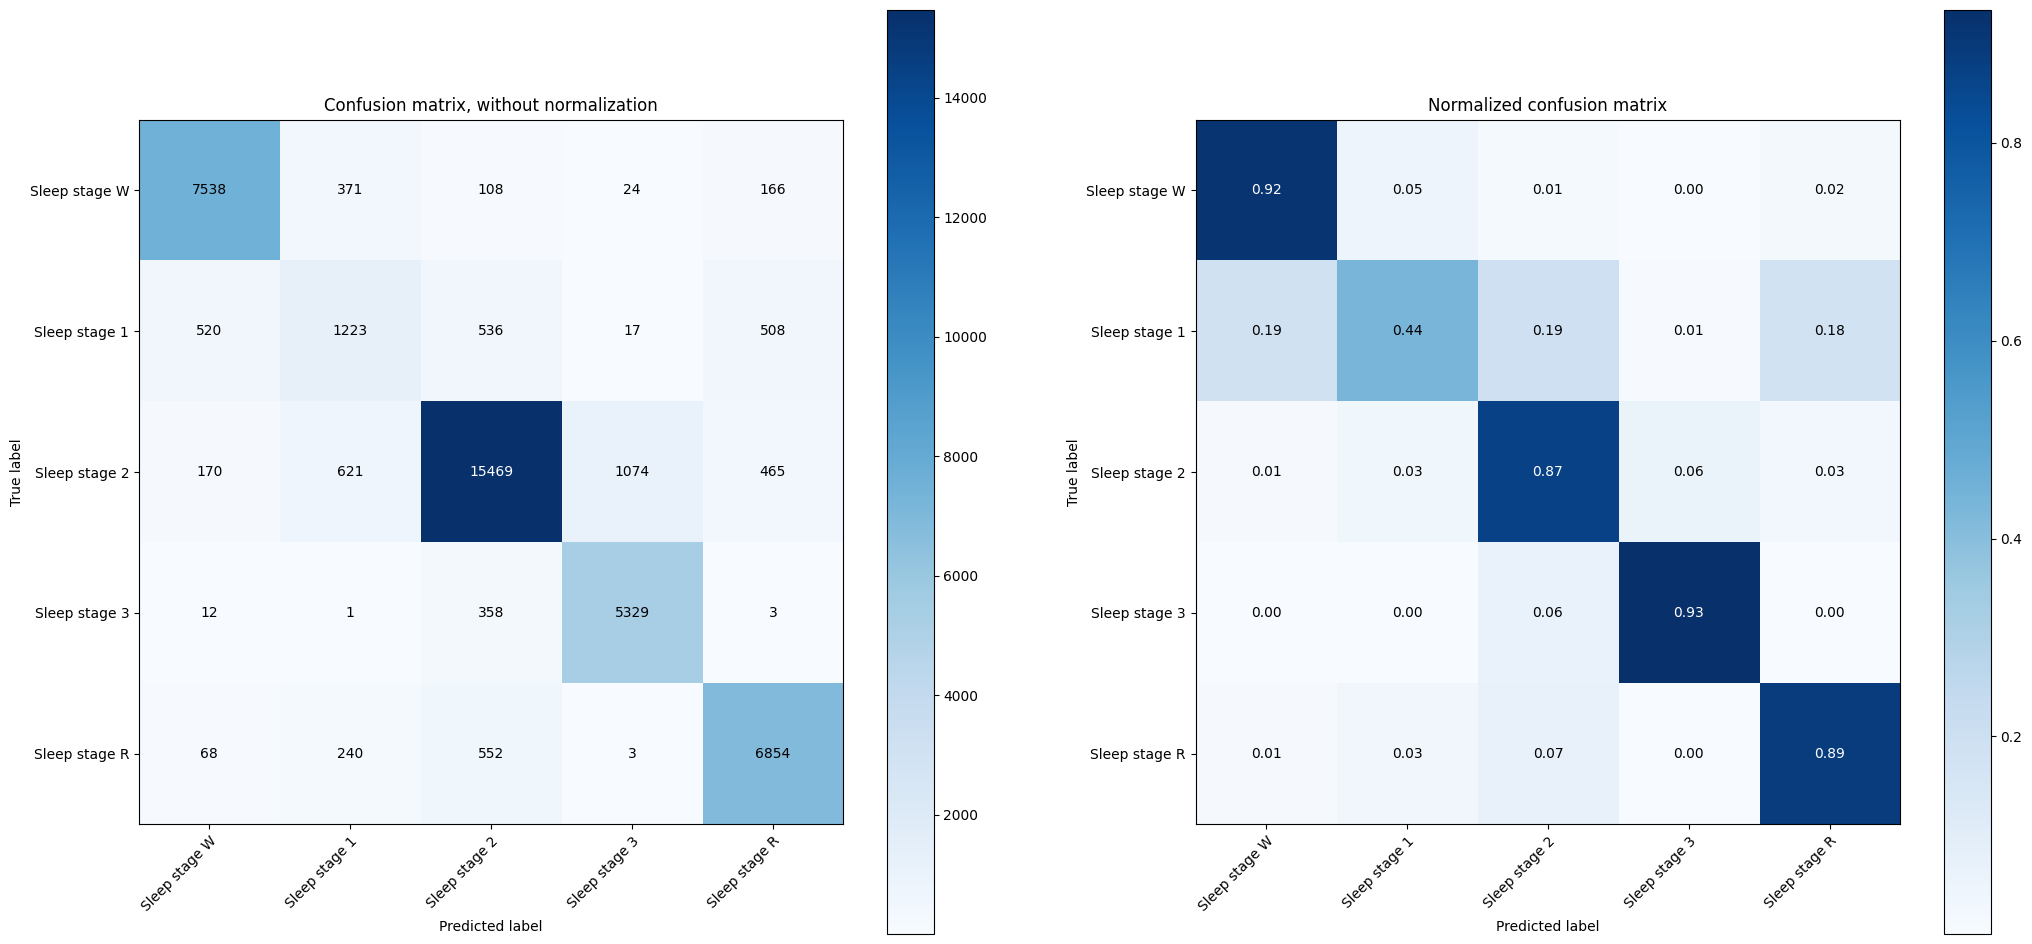

In [65]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

    The model performs best at classifying sleep stage W (wake), with high true positives (7538) and relatively low misclassifications.
    
    Sleep stage R (REM) is also classified well, with 15469 true positives and fewer misclassifications compared to other stages.
    
    The model has more difficulty distinguishing between sleep stages 1, 2, and 3, as evident from the higher number of misclassifications between these stages.
    
    Sleep stage 3 has the lowest number of true positives (5329) and is often misclassified as sleep stage 2 (358 instances).
    
    The normalized confusion matrix shows that the model has high precision for sleep stage W (0.92) and sleep stage R (0.87), while the precision for stages 1, 2, and 3 is lower (0.44, 0.87, and 0.93, respectively).
    
    The recall (sensitivity) is highest for sleep stage R (0.87) and sleep stage W (0.92), while it is lower for stages 1, 2, and 3 (0.19, 0.87, and 0.06, respectively).

In [66]:
import joblib
joblib.dump(pipe, "models/pipe_DT_SC-20.pkl")

['models/pipe_DT_SC-20.pkl']

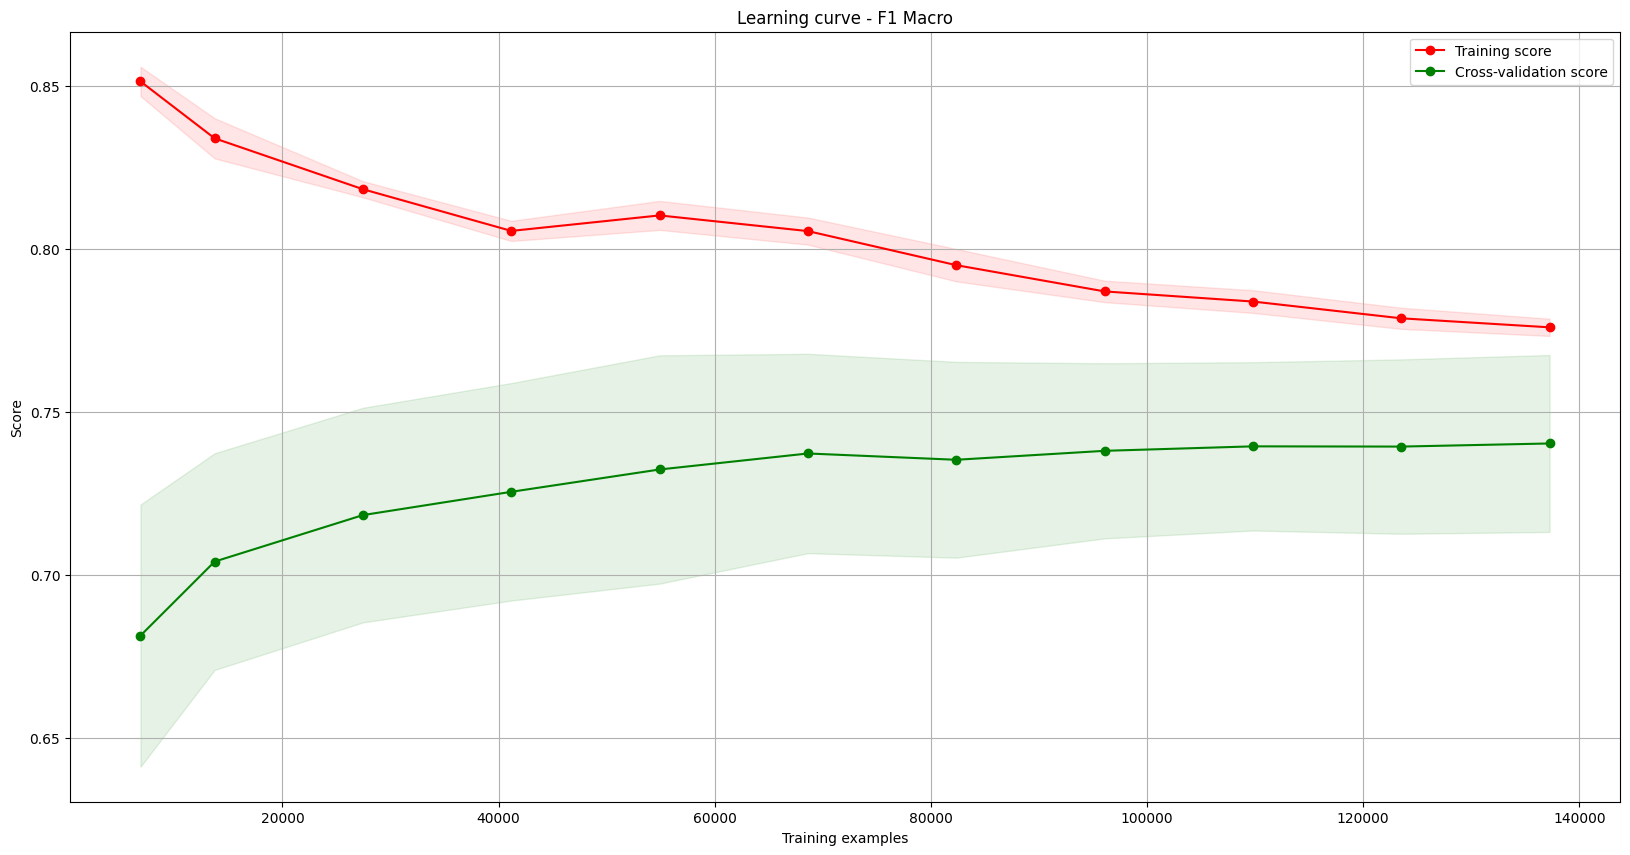

In [67]:
cv = StratifiedGroupKFold(n_splits=10).split(
    df_feats_trimmed[feat_cols],
    df_feats_trimmed["label"],
    groups=df_feats_trimmed.patient_id,
)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats_trimmed[feat_cols],
    y=df_feats_trimmed["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

#### Basic model analysis

Here, we plot the top coefficients of the simple logistic regression model. The absolute coefficients are plotted on a horizontal barplot. The color indicates whether the coefficient is positive (green) or negative (red).

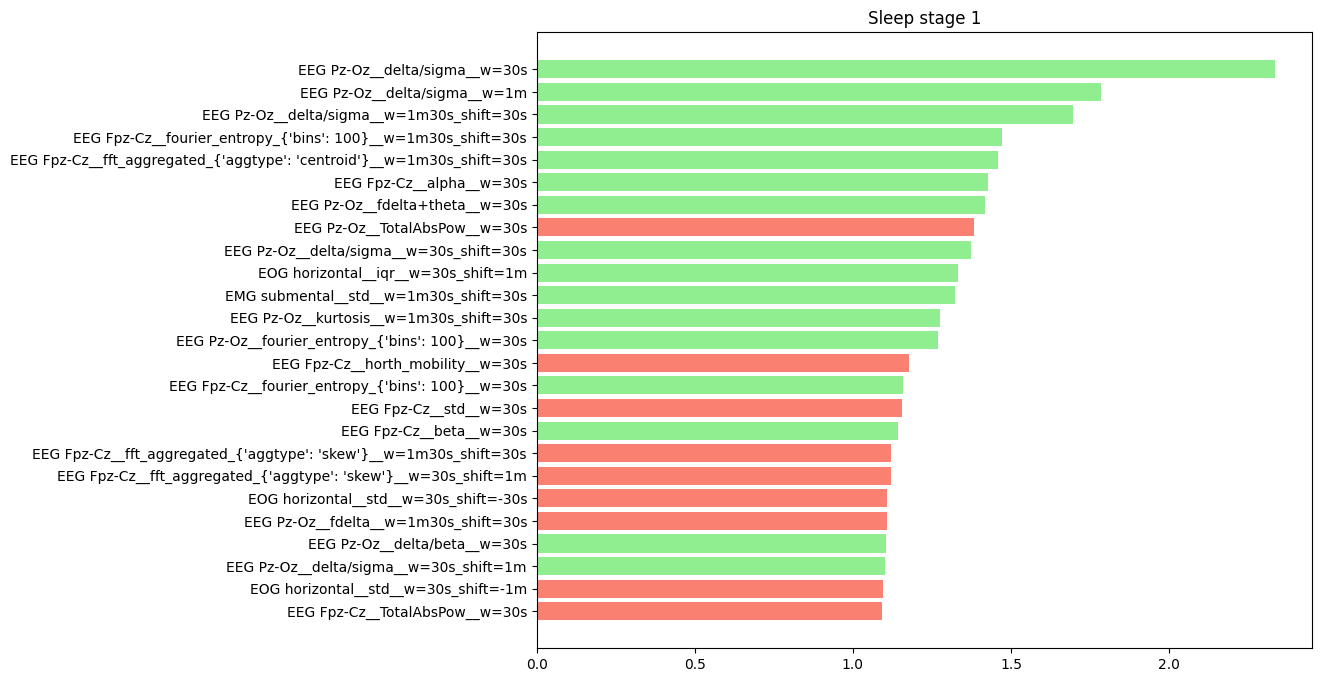

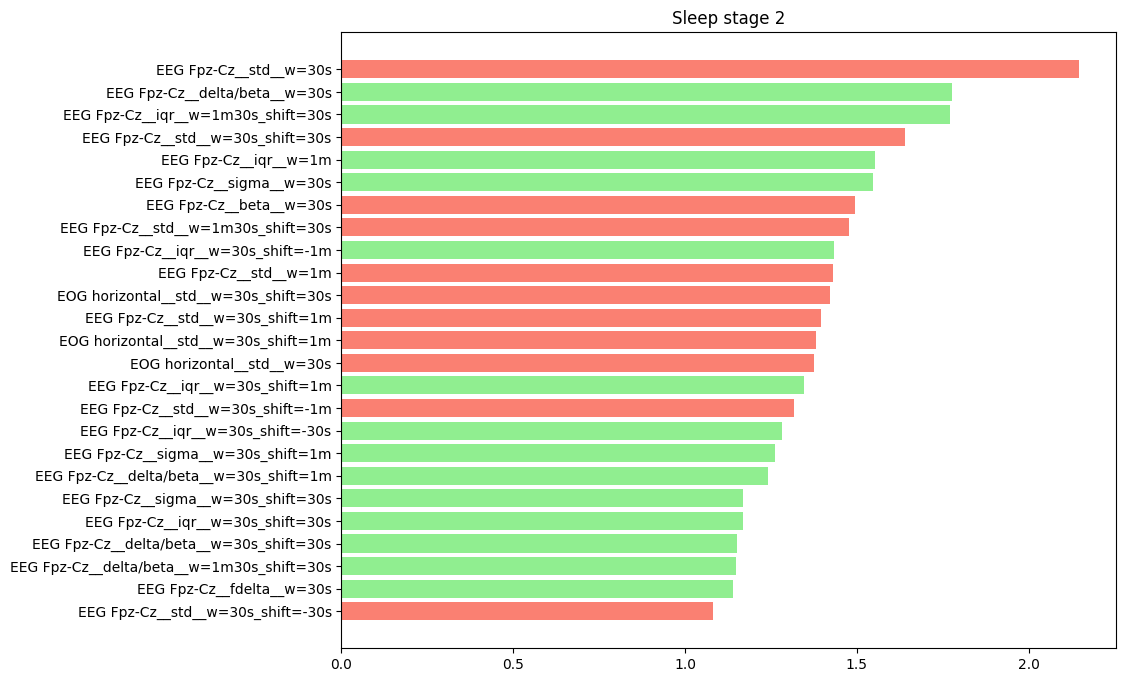

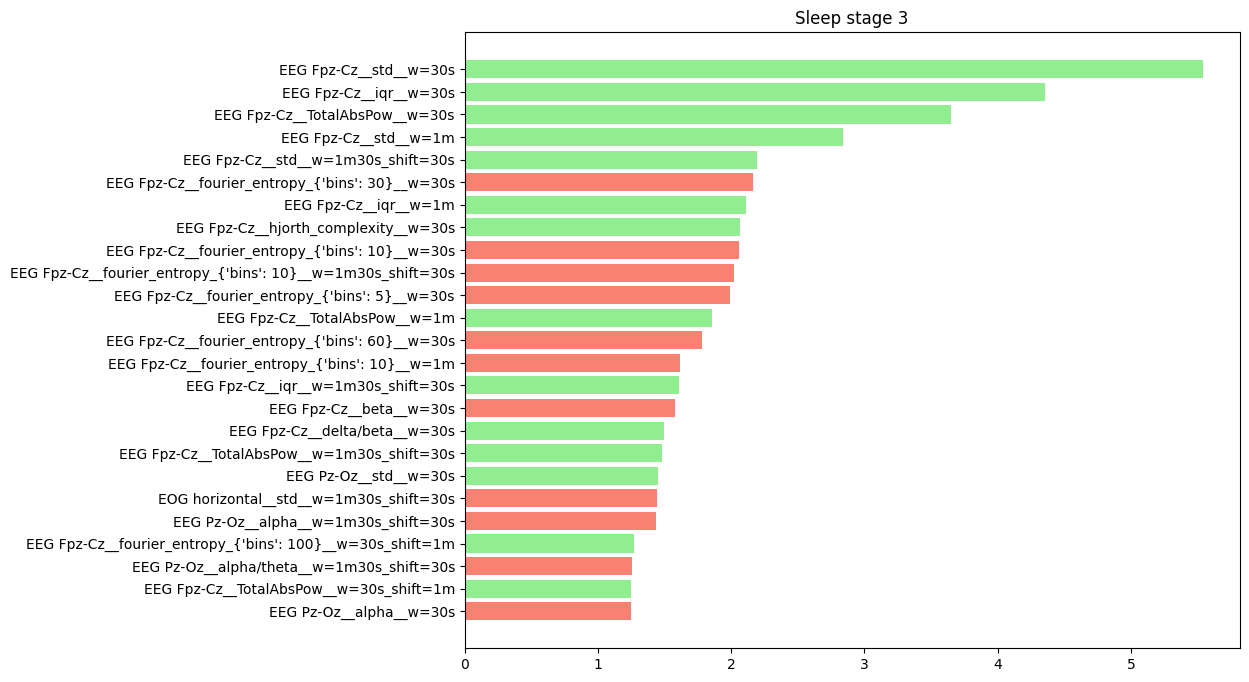

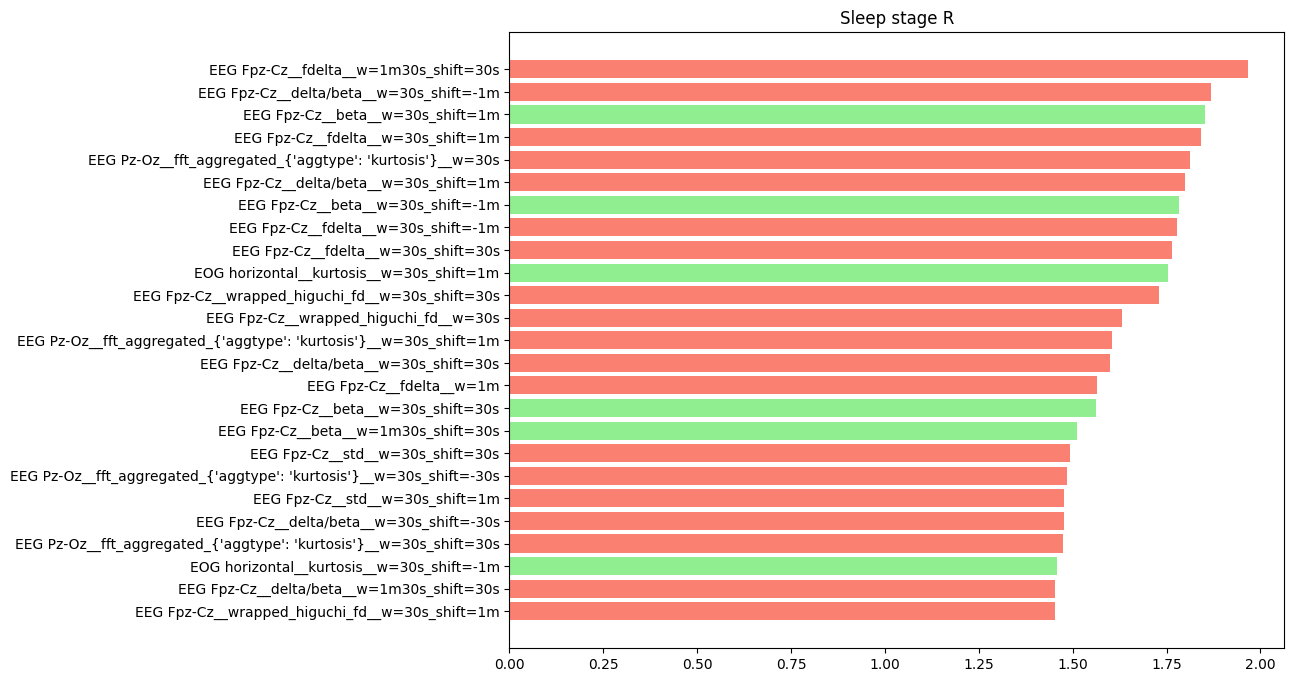

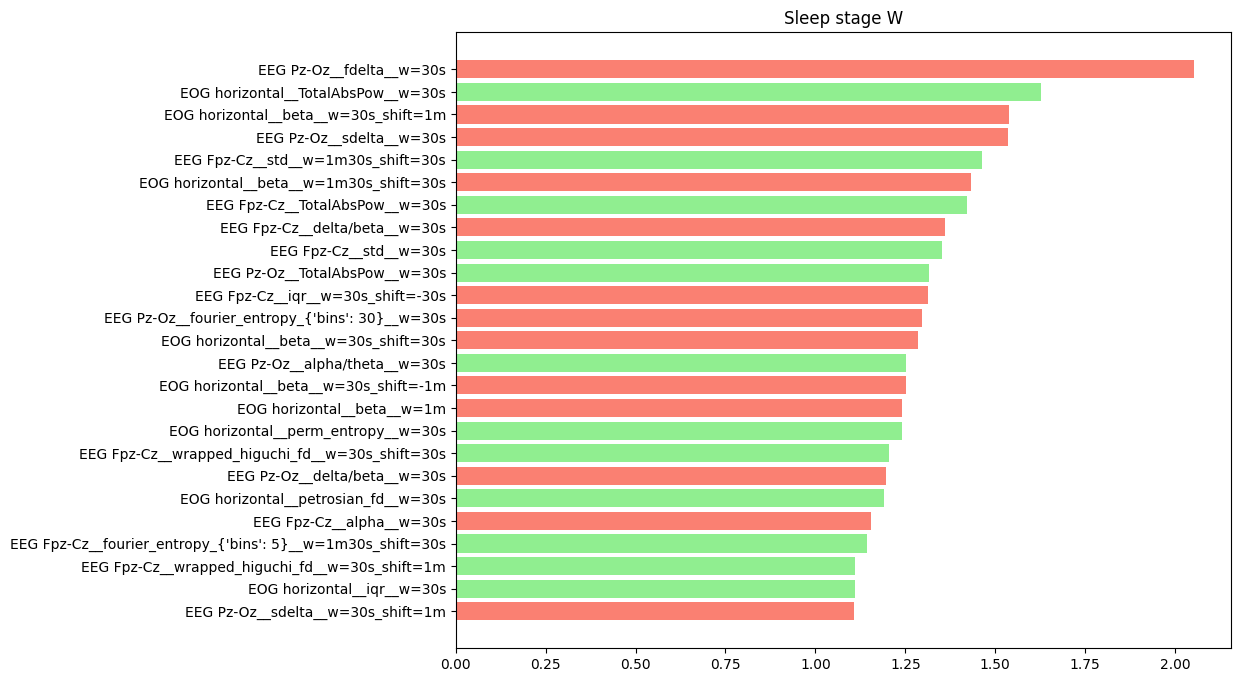

In [68]:
plot_linear_classification_coefs(pipe, feat_cols=feat_cols)

In [69]:
df_impact = pd.DataFrame()
df_impact["feature"] = feat_cols
for i, c in enumerate(pipe.classes_):
    df_impact[f"weight_{c}"] = pipe[-1].coef_[i,:]
df_impact["max_abs"] = df_impact.filter(like="weight_").abs().max(axis=1)
df_impact["mean_abs"] = df_impact.filter(like="weight_").abs().mean(axis=1)

def get_shift(feat_name: str):
    if not "shift=" in feat_name or "w=1m" in feat_name:
        return "0"
    return feat_name.split("shift=")[-1]
df_impact["shift"] = df_impact.feature.apply(get_shift)
# print(df_impact["shift"].value_counts())

def get_window_size(feat_name: str):
    return feat_name.split("__w=")[1].split("_")[0]

df_impact["win_size"] = df_impact.feature.apply(get_window_size)
# print(df_impact["win_size"].value_counts())
# print(df_impact[df_impact["shift"] == "0"]["win_size"].value_counts())

df_impact.head(5)

,feature,weight_Sleep stage 1,weight_Sleep stage 2,weight_Sleep stage 3,weight_Sleep stage R,weight_Sleep stage W,max_abs,mean_abs,shift,win_size
0,EEG Fpz-Cz__TotalAbsPow__w=1m,-0.493135,0.330052,1.855882,-0.530216,0.538263,1.855882,0.749510,0,1m
1,EEG Fpz-Cz__TotalAbsPow__w=30s,-1.091115,-0.306885,3.652044,-0.850321,1.421226,3.652044,1.464318,0,30s
2,EEG Fpz-Cz__alpha__w=1m,0.669985,0.117223,0.046510,0.364889,-0.739652,0.739652,0.387652,0,1m
3,EEG Fpz-Cz__alpha__w=30s,1.426636,0.151527,-0.453603,0.129377,-1.154698,1.426636,0.663168,0,30s
4,EEG Fpz-Cz__beta__w=1m,0.547306,-0.713789,-0.975213,1.417851,0.379539,1.417851,0.806739,0,1m


C:\Users\W11\AppData\Local\Temp\ipykernel_14180\2814284842.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: title={'center': 'Mean weight per shifted feature'}, xlabel='shift', ylabel='mean_abs'>

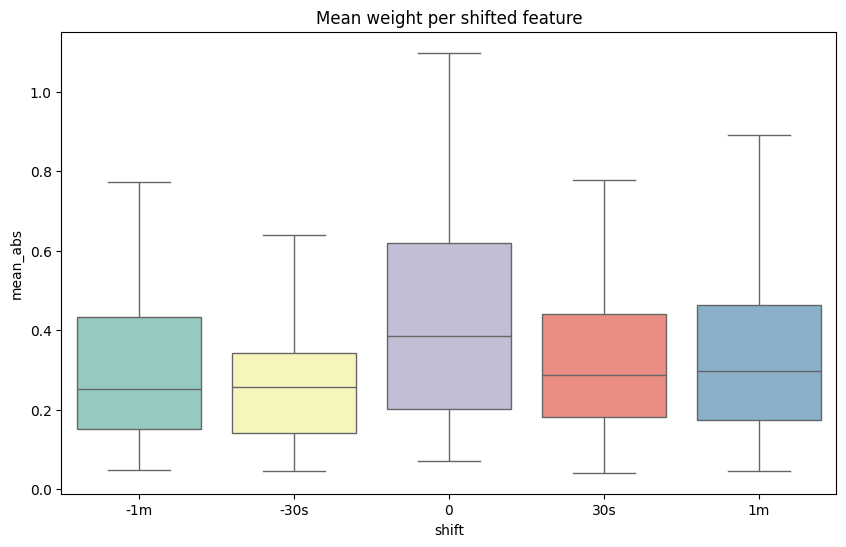

In [70]:
import seaborn as sns

sub_df = df_impact[df_impact["win_size"] == "30s"]

plt.figure(figsize=(10,6))
plt.title("Mean weight per shifted feature")
# sns.set_context("talk")
sns.boxplot(
    x=sub_df["shift"],
    y=sub_df["mean_abs"],
    order=["-1m", "-30s", "0", "30s", "1m"],
    showfliers=False,
    palette="Set3",
    # height=8,
    # aspect=2,
)

C:\Users\W11\AppData\Local\Temp\ipykernel_14180\2505149063.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




<Axes: title={'center': 'Mean weight per feature window'}, xlabel='window', ylabel='mean_abs'>

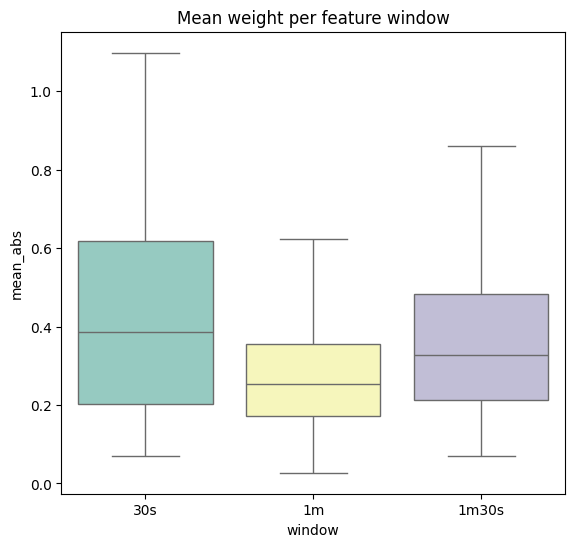

In [71]:
import seaborn as sns

sub_df = df_impact[df_impact["shift"] == "0"]

plt.figure(figsize=(6.5,6))
plt.title("Mean weight per feature window")
# sns.set_context("talk")
sns.boxplot(
    x=sub_df["win_size"].rename("window"),
    y=sub_df["mean_abs"],
    order=["30s", "1m", "1m30s"],
    showfliers=False,
    palette="Set3",
    # height=8,
    # aspect=2,
)

### Grouped X-fold on SC-20

In [72]:
import time
start = time.time()
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)
end = time.time()

print(end - start)

82.1480963230133


In [73]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))


20-FOLD: TRAIN
  MACRO F1:           0.8496
  Balanced accuracy:  0.8633
  Accuracy:           0.8876
  Log loss:           0.5431


In [74]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.7961
  Balanced accuracy:  0.8245
  Accuracy:           0.8544
  Log loss:           0.8265


In [75]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [76]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8069900673783025
ACC: 0.8552924461283448
KAPPA: 0.8037314709036338
LOG LOSS: 0.8295043198949561


In [77]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.56      0.45      0.50      3499
Sleep stage 2       0.85      0.91      0.88     16719
Sleep stage 3       0.92      0.83      0.87      6265
Sleep stage R       0.89      0.87      0.88      7866
Sleep stage W       0.89      0.92      0.90      7881

     accuracy                           0.86     42230
    macro avg       0.82      0.80      0.81     42230
 weighted avg       0.85      0.86      0.85     42230



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

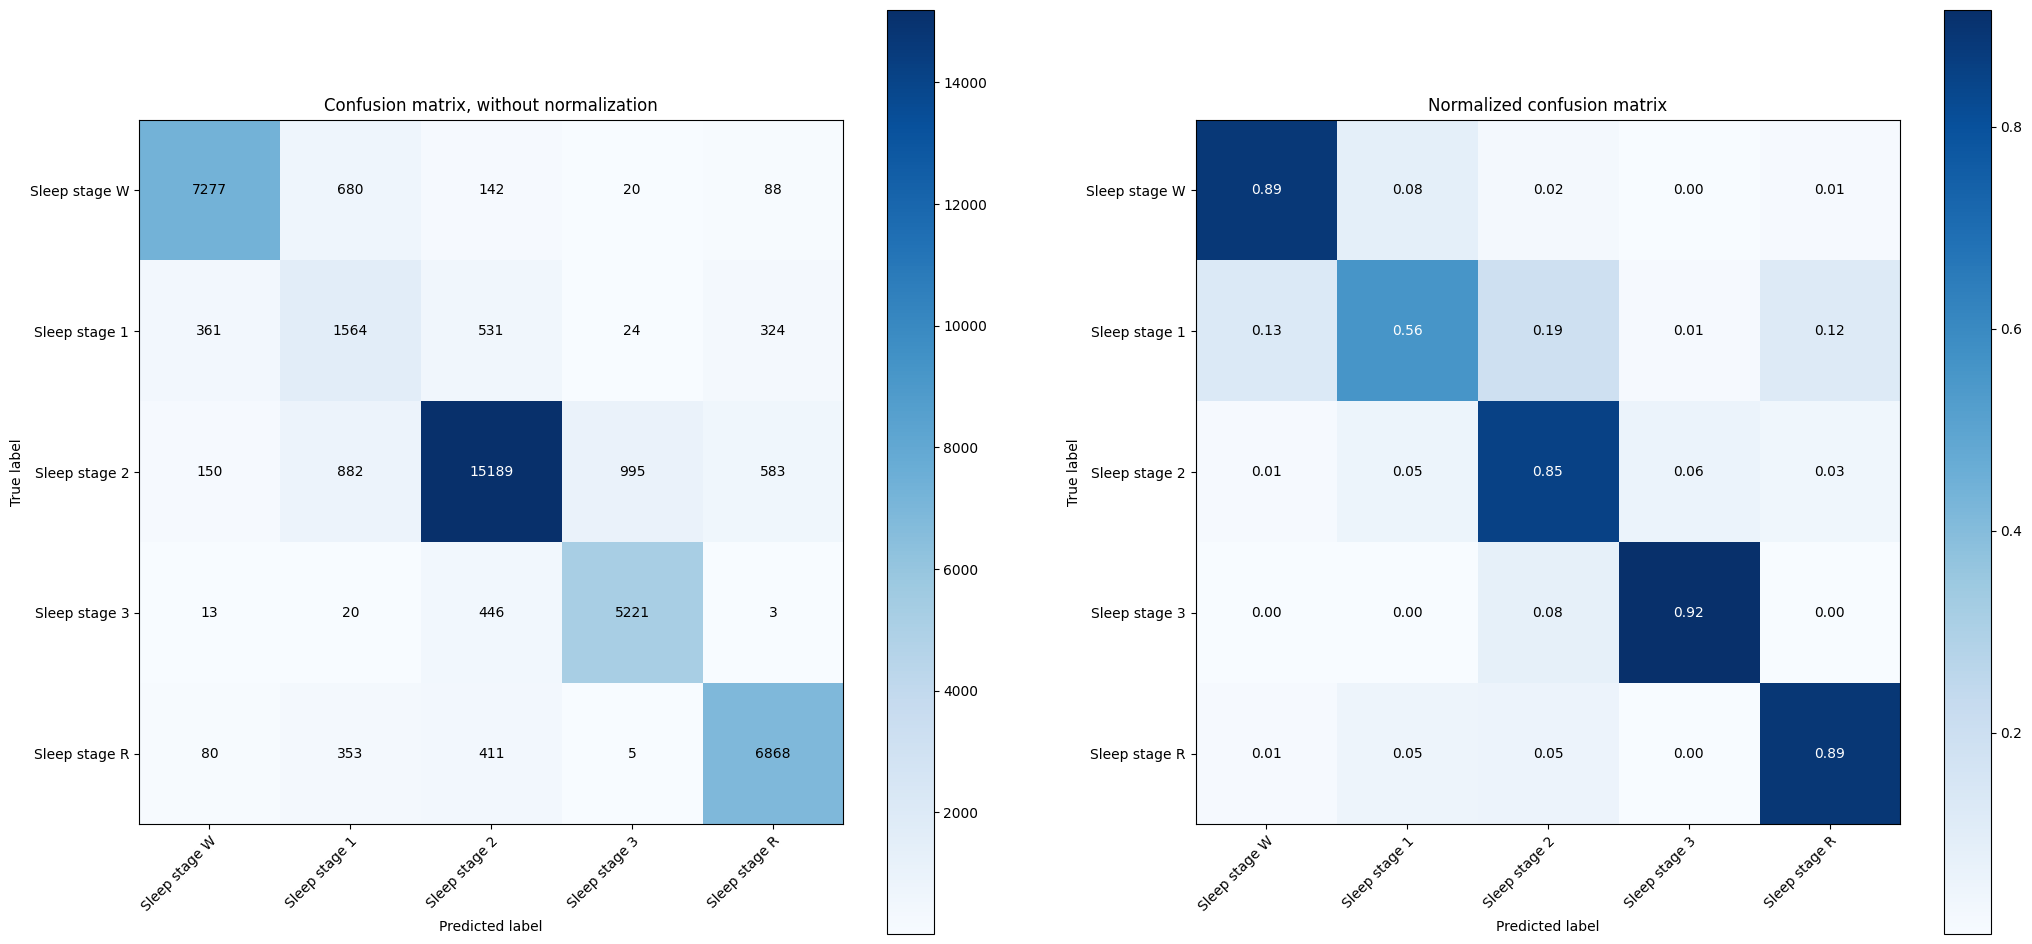

In [78]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

In the confusion matrix without normalization:

    The model performs very well at predicting sleep stage W (wake), with 7277 correct predictions and relatively few misclassifications.
    Performance is decent for sleep stages 1 and R, but there is more confusion between these stages and others.
    The model struggles most with sleep stages 2 and 3, frequently misclassifying stage 2 as stage 3 and vice versa. Stage 3 is correctly identified only 5221 times out of 5749 true stage 3 epochs.

The normalized confusion matrix makes the patterns clearer:


    Accuracy is highest for stage W at 89%.
    Stages 1 and R have accuracies of 56% and 89% respectively.
    Stages 2 and 3 have quite low accuracies of 85% and 52%. There is a lot of confusion between these two stages, with stage 2 frequently predicted as stage 3 (8% of the time) and stage 3 predicted as stage 2 (48% of the time).

## The simple, catboost pipeline

In [79]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

## Catboost model for SC-20

### Direct transfer from other 58 patients (114 PSGs) to SC-20

* Train & validatie on all patients except the SC-20 patients (i.e., patient_id > 19)
* Test the trained model on those 20 patients (i.e., patient_id in [0-19])

In [80]:
import time 

In [81]:
### Fit the pipeline
bas = time.time()
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])
son = time.time()
print(son-bas)

817.1011431217194


In [82]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:
Log loss: 0.27833637398161853
               precision    recall  f1-score   support

Sleep stage 1       0.75      0.60      0.67     18716
Sleep stage 2       0.87      0.93      0.90     51333
Sleep stage 3       0.89      0.81      0.85      7336
Sleep stage R       0.90      0.90      0.90     18118
Sleep stage W       0.96      0.97      0.96     57435

     accuracy                           0.90    152938
    macro avg       0.87      0.84      0.86    152938
 weighted avg       0.89      0.90      0.89    152938



In [83]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:
Log loss: 0.3614819198828771
               precision    recall  f1-score   support

Sleep stage 1       0.51      0.47      0.49      2804
Sleep stage 2       0.88      0.90      0.89     17799
Sleep stage 3       0.88      0.90      0.89      5703
Sleep stage R       0.90      0.84      0.87      7717
Sleep stage W       0.90      0.94      0.92      8207

     accuracy                           0.87     42230
    macro avg       0.81      0.81      0.81     42230
 weighted avg       0.86      0.87      0.86     42230



In [84]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))

F1 macro:  0.810086957600579
Bal. Acc:  0.813483934017459
Kappa:     0.8154547075836651
Log loss : 0.3614819198828771
Acc:       0.8659246980819323


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

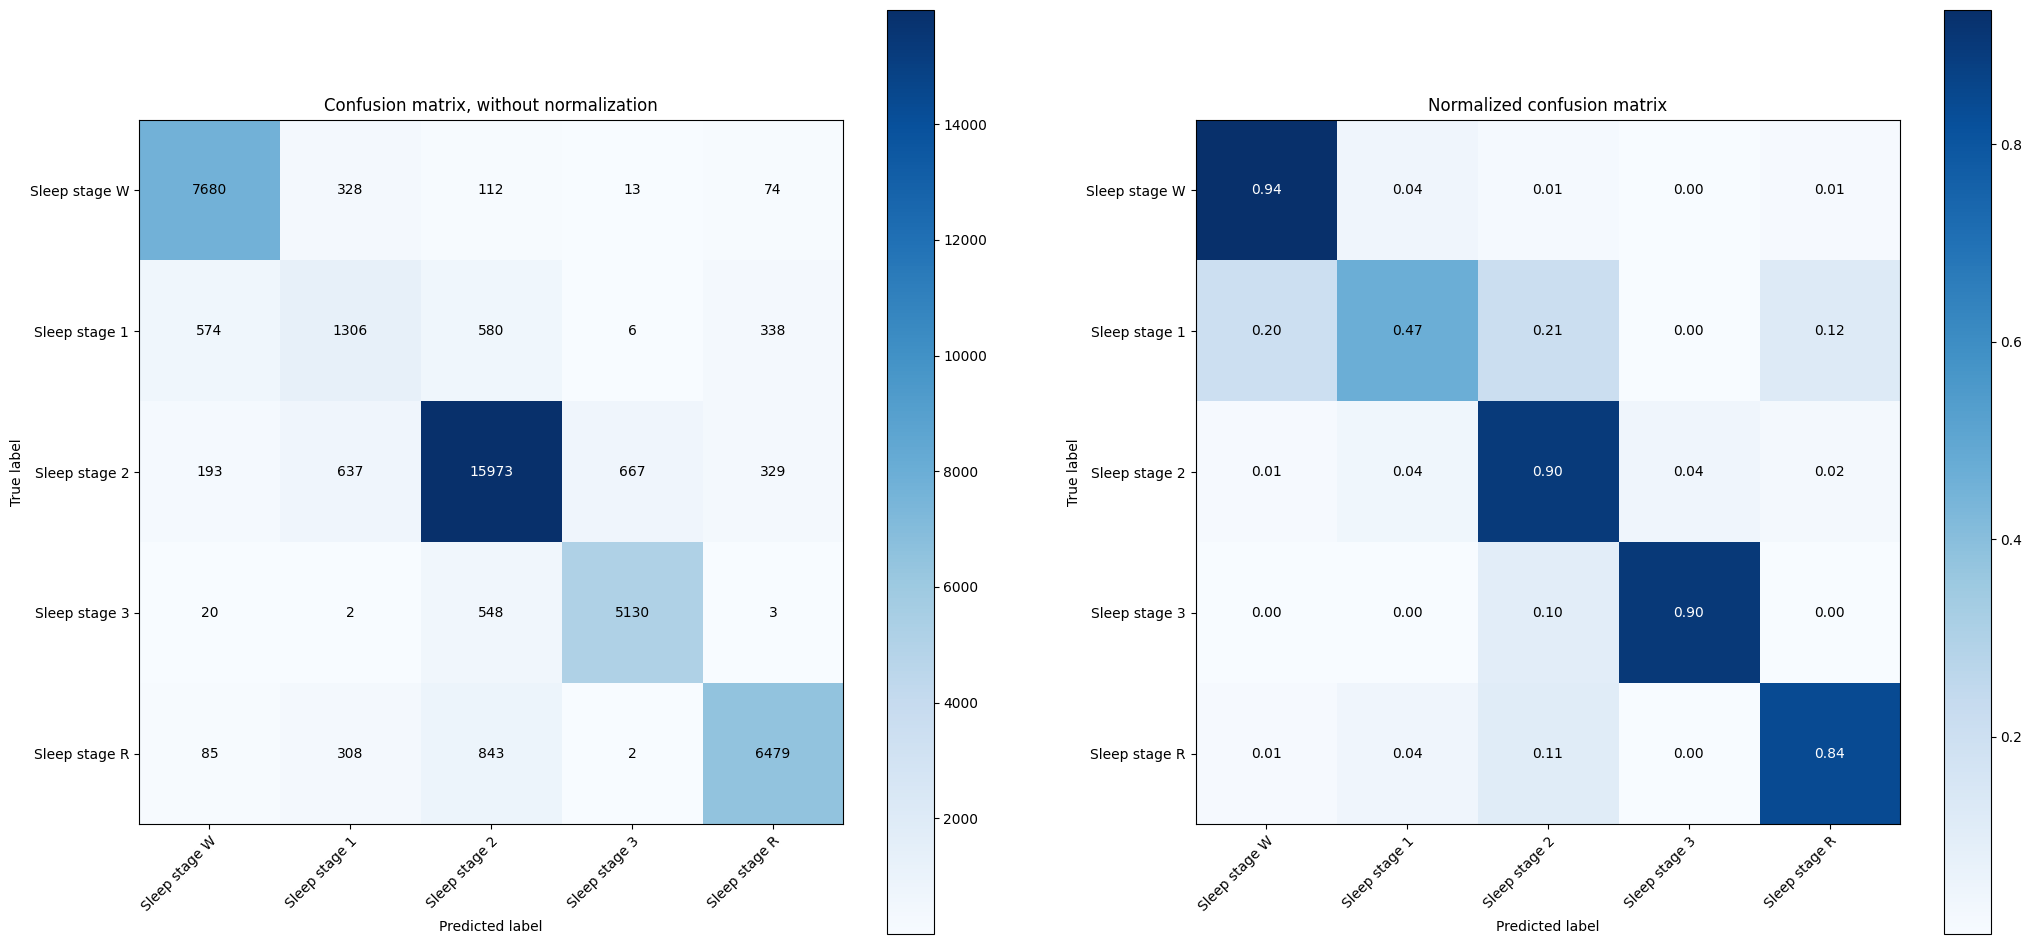

In [85]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

    The model performs best at classifying Sleep stage W (wake), with high true positives (7680) and relatively low misclassifications.
    
    Sleep stage R is also classified well, with 6479 true positives and low misclassifications.
    
    The model struggles most with Sleep stage 1, frequently misclassifying it as Sleep stage 2 (580 instances) or Sleep stage W (574 instances). True positives for Sleep stage 1 are only 1306.
    
    Sleep stage 2 and 3 have decent classification performance, with the majority of instances along the diagonal (true positives). However, there is some confusion between these two stages.
    
    The normalized matrix shows that the model is over 90% accurate in classifying Sleep stage W and R. Accuracy is lower for the other stages, especially Sleep stage 1 at only 47%.
    
    Misclassification rates are highest between Sleep stage 1 and 2 (21% of stage 1 instances misclassified as stage 2, 20% of stage 1 misclassified as stage W).

In [86]:
import joblib
joblib.dump(pipe, "models/catboost_DT_SC-20.pkl")

['models/catboost_DT_SC-20.pkl']

### Grouped X-fold on SC-20

In [88]:
# Total of 20 folds
gkfold = GroupKFold(n_splits=20)
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)

res = cross_validate(
    pipe,
    df_feats_trimmed_paper[feat_cols],
    df_feats_trimmed_paper["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [89]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

20-FOLD: TRAIN
  MACRO F1:           0.9263
  Balanced accuracy:  0.9157
  Accuracy:           0.9459
  Log loss:           0.1653


In [90]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.7967
  Balanced accuracy:  0.803
  Accuracy:           0.8653
  Log loss:           0.3638


In [91]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats_trimmed_paper, groups=df_feats_trimmed_paper.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats_trimmed_paper[feat_cols].iloc[train_idx]
    y_train = df_feats_trimmed_paper["label"].iloc[train_idx]
    X_test = df_feats_trimmed_paper[feat_cols].iloc[test_idx]
    y_test = df_feats_trimmed_paper["label"].iloc[test_idx]

    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [92]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8030646188984265
ACC: 0.8642197489936064
KAPPA: 0.8124462832401194
LOG LOSS: 0.36754415446529687


In [93]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.41      0.53      0.46      2180
Sleep stage 2       0.91      0.88      0.89     18312
Sleep stage 3       0.89      0.89      0.89      5740
Sleep stage R       0.87      0.87      0.87      7726
Sleep stage W       0.91      0.90      0.90      8272

     accuracy                           0.86     42230
    macro avg       0.80      0.81      0.80     42230
 weighted avg       0.87      0.86      0.87     42230



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

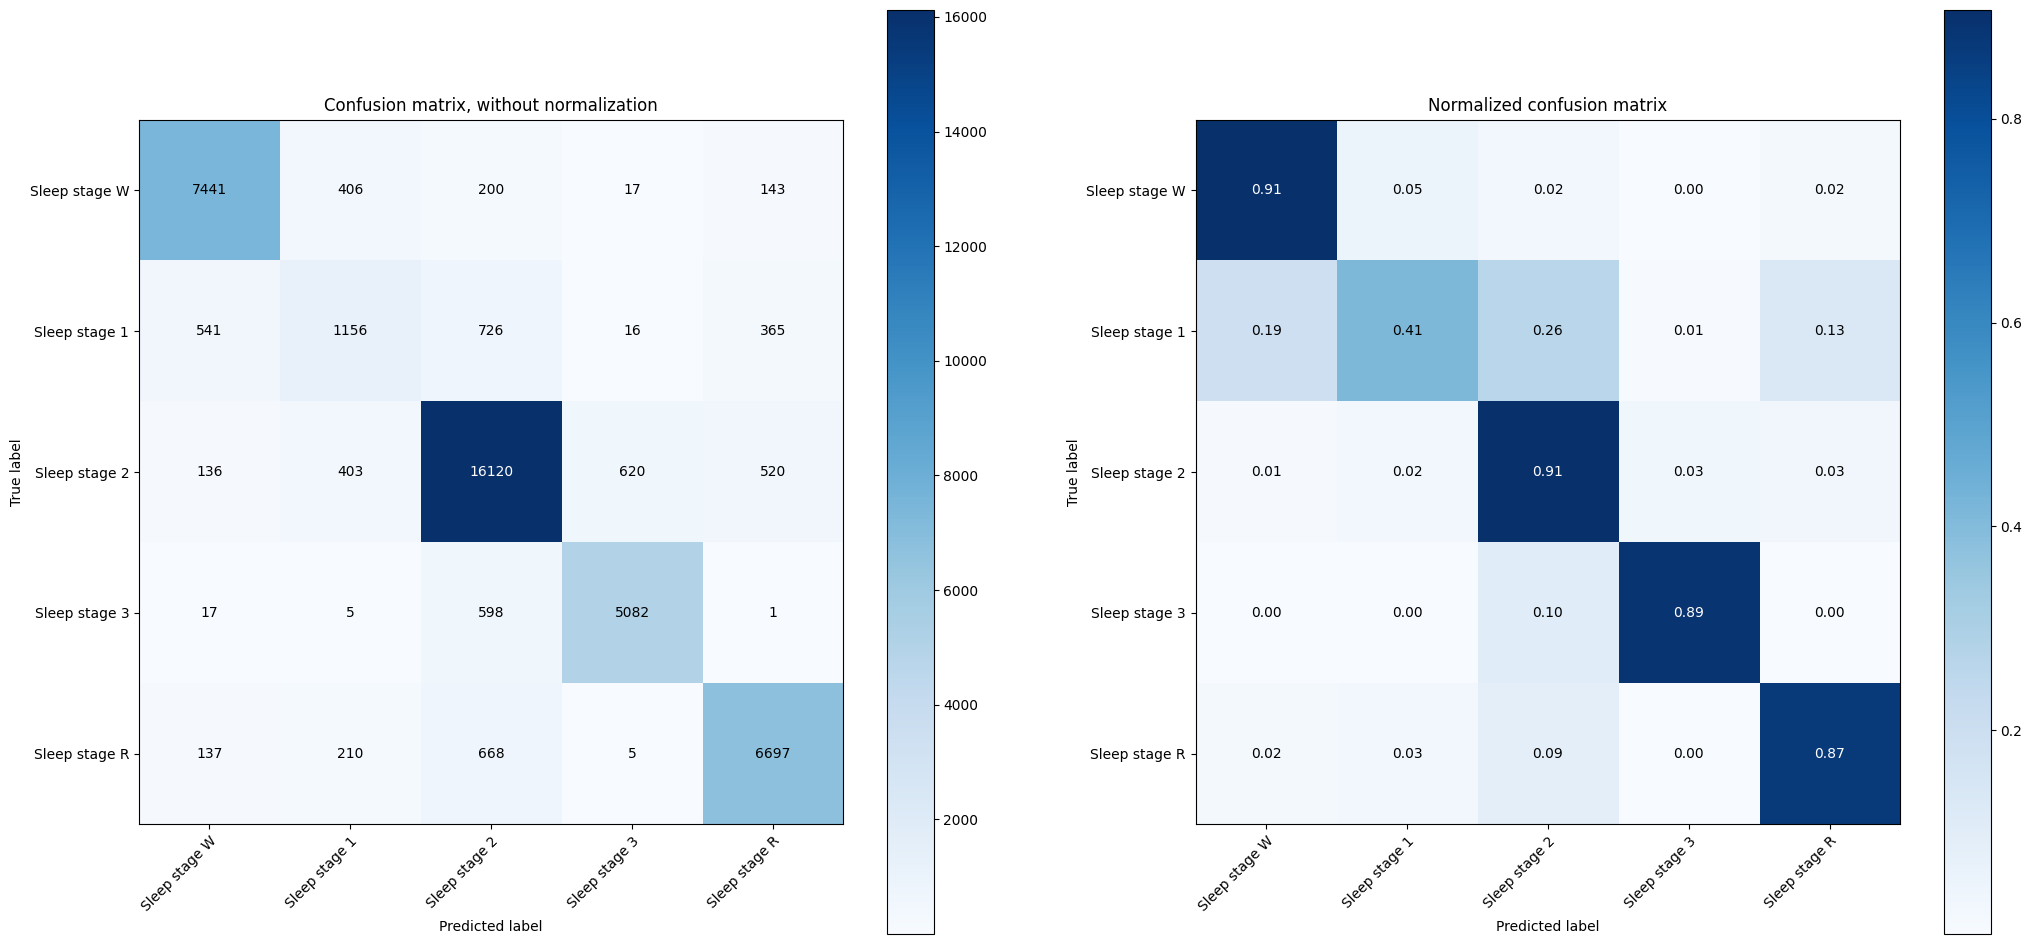

In [94]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

Without normalization :

    The model performs well in predicting sleep stage R, with 6697 correct predictions out of 6697+5+668+210+137 = 7717 total instances.
    Sleep stage 3 also has a high number of correct predictions (5082 out of 5082+598+5+17 = 5702 instances).
    Sleep stage 2 has the most instances (16120) and a significant number of correct predictions (16120 out of 16120+620+403+136 = 17279 instances).
    Sleep stage 1 and W (wake) have more misclassifications compared to the other stages.

With normalization :

    
    Sleep stage R has the highest normalized value (0.87) on the diagonal, indicating the best performance among all stages.
    Sleep stage 3 follows with a normalized value of 0.89 on the diagonal.
    Sleep stage 2 has a normalized value of 0.91 on the diagonal, showing good performance.
    Sleep stage 1 and W have lower normalized values on the diagonal (0.41 and 0.91, respectively), indicating more misclassifications.

## TinySleepNet

In [98]:
import tensorflow as tf

In [99]:
# set data
from sklearn.preprocessing import LabelEncoder

imputer = SimpleImputer(strategy='mean')
imputer.fit(df_feats_trimmed[feat_cols])
df_train_imputed = pd.DataFrame(imputer.transform(df_feats_trimmed[feat_cols]), columns=feat_cols)
df_test_imputed = pd.DataFrame(imputer.transform(df_feats_trimmed_paper[feat_cols]), columns=feat_cols)

scaler = QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)
scaler.fit(df_train_imputed)
df_train_scaled = pd.DataFrame(scaler.transform(df_train_imputed), columns=feat_cols)
df_test_scaled = pd.DataFrame(scaler.transform(df_test_imputed), columns=feat_cols)

label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(df_feats_trimmed['label'])
test_labels = label_encoder.transform(df_feats_trimmed_paper['label'])

In [100]:
from tensorflow.keras import layers, Model

def TinySleepNet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2)(x)
    
    x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='TinySleepNet')
    return model

# Define input shape and number of classes
input_shape = (917, 1)  # Assuming EEG signals are represented as a 1D signal with 920 features
num_classes = 5  # Number of sleep stages

# Instantiate the model
model = TinySleepNet(input_shape, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "TinySleepNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 917, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 917, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 917, 32)           5152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 458, 32)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 458, 64)           10304     
                                                                 
 conv1d_3 (Conv1D)           (None, 458, 64)           20544     
                                                      

In [101]:
history = model.fit(x = df_train_scaled, y=train_labels, batch_size = 32, epochs=5, validation_data=(df_test_scaled, test_labels))

Epoch 1/5
4780/4780 [==============================] - 41s 7ms/step - loss: 0.4776 - accuracy: 0.8233 - val_loss: 0.4692 - val_accuracy: 0.8525
Epoch 2/5
4780/4780 [==============================] - 33s 7ms/step - loss: 0.4506 - accuracy: 0.8330 - val_loss: 0.4300 - val_accuracy: 0.8558
Epoch 3/5
4780/4780 [==============================] - 33s 7ms/step - loss: 0.4709 - accuracy: 0.8274 - val_loss: 0.7642 - val_accuracy: 0.7895
Epoch 4/5
4780/4780 [==============================] - 34s 7ms/step - loss: 0.4973 - accuracy: 0.8208 - val_loss: 0.4984 - val_accuracy: 0.8438
Epoch 5/5
4780/4780 [==============================] - 33s 7ms/step - loss: 0.5122 - accuracy: 0.8170 - val_loss: 0.7615 - val_accuracy: 0.8266


In [102]:
print("Training data:")
preds_proba = model.predict(df_train_scaled)
preds = np.argmax(preds_proba, axis=1)
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=train_labels, y_pred=preds, target_names=classes))

Training data:
4780/4780 [==============================] - 8s 2ms/step
Log loss: 0.68149109480177
               precision    recall  f1-score   support

Sleep stage W       0.49      0.46      0.48     18716
Sleep stage 1       0.79      0.90      0.84     51333
Sleep stage 2       0.90      0.56      0.69      7336
Sleep stage 3       0.89      0.69      0.78     18118
Sleep stage R       0.92      0.93      0.93     57435

     accuracy                           0.82    152938
    macro avg       0.80      0.71      0.74    152938
 weighted avg       0.82      0.82      0.81    152938



In [103]:
print("Testing data:")
preds_proba = model.predict(df_test_scaled)
preds = np.argmax(preds_proba, axis=1)
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=test_labels, y_pred=preds, target_names=classes))

Testing data:
1320/1320 [==============================] - 2s 2ms/step
Log loss: 0.7537761725870493
               precision    recall  f1-score   support

Sleep stage W       0.40      0.50      0.45      2804
Sleep stage 1       0.82      0.92      0.87     17799
Sleep stage 2       0.94      0.77      0.85      5703
Sleep stage 3       0.93      0.68      0.78      7717
Sleep stage R       0.90      0.91      0.90      8207

     accuracy                           0.83     42230
    macro avg       0.80      0.76      0.77     42230
 weighted avg       0.84      0.83      0.83     42230



In [104]:
print("F1 macro: ", f1_score(preds, test_labels, average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, test_labels))
print("Kappa:    ", cohen_kappa_score(preds, test_labels))
print("Log loss :", log_loss(y_true=test_labels, y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, test_labels))

F1 macro:  0.769500252837845
Bal. Acc:  0.7976577993110766
Kappa:     0.7578078155187555
Log loss : 0.7537761725870493
Acc:       0.8265687899597443


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

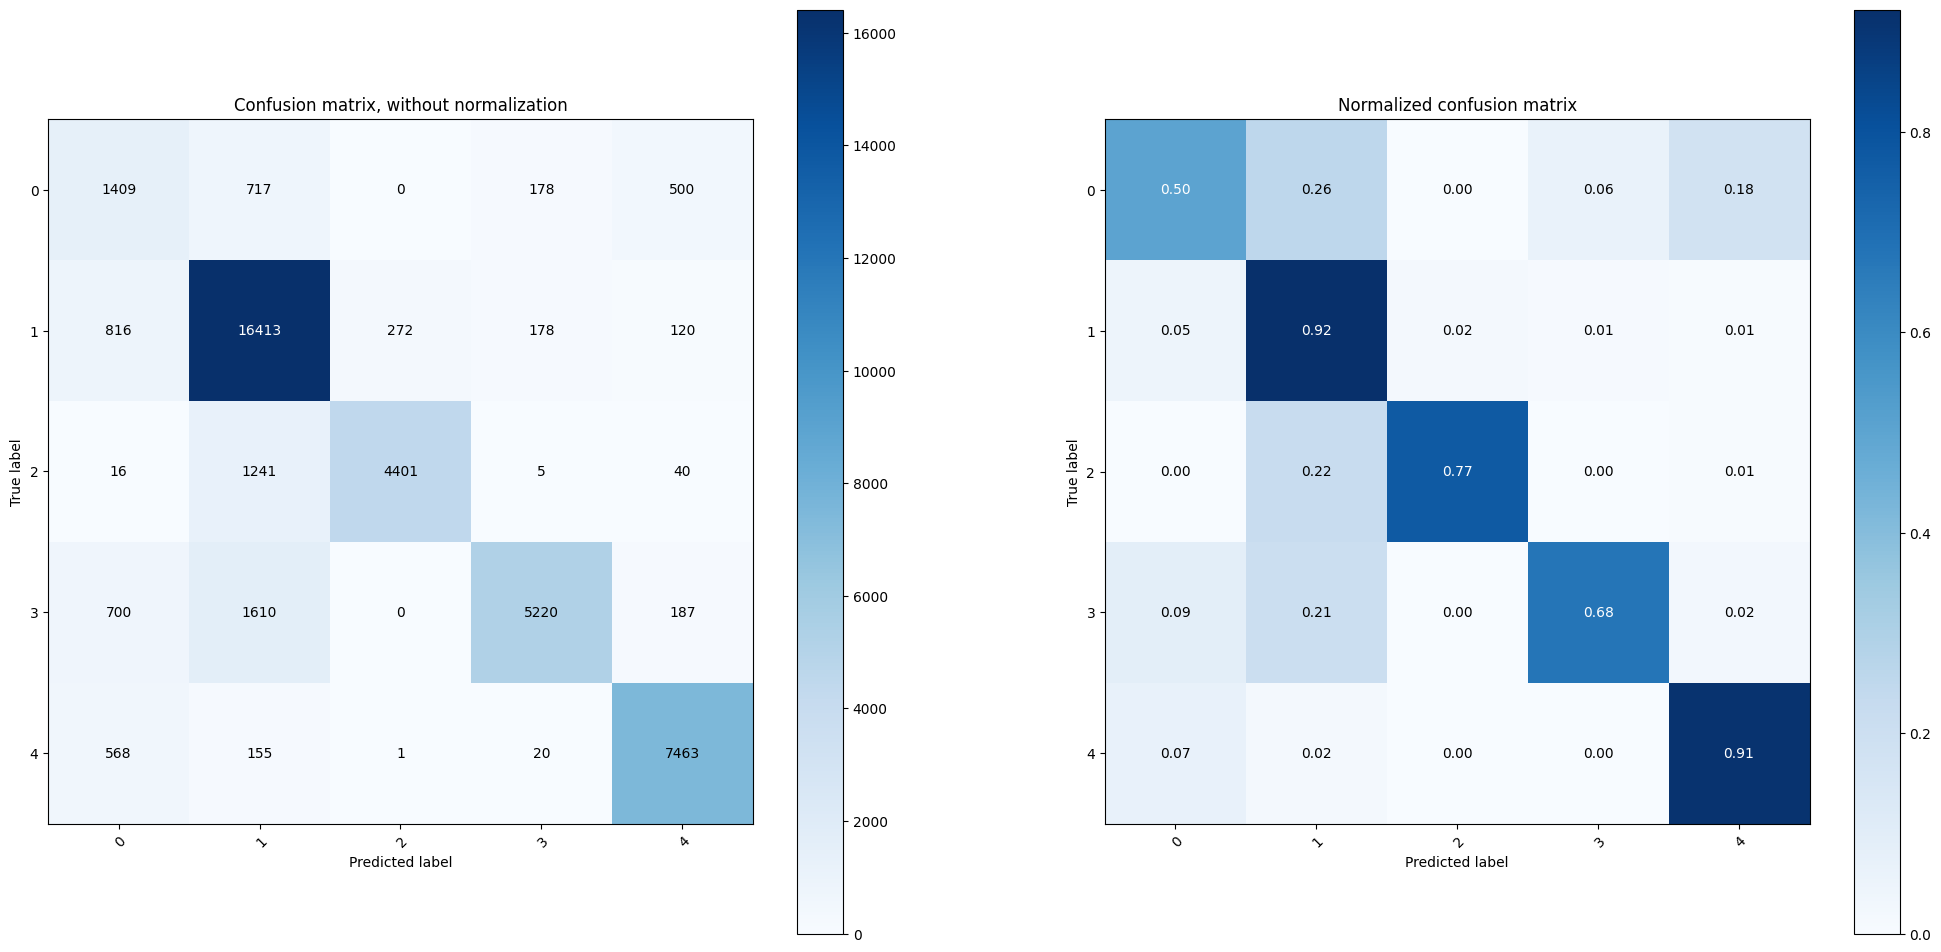

In [105]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=test_labels, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=test_labels, normalize=True, ax=ax)

In the unnormalized matrix on the left:

    The model performs best at predicting class 4, with 7463 correct predictions and relatively few misclassifications.
    Class 2 also has a high number of correct predictions at 4401.
    The model struggles more with classes 0, 1 and 3, having a significant number of misclassifications for each.
    In particular, there is a lot of confusion between classes 0 and 1, and between classes 3 and 2.

The normalized matrix on the right makes the class imbalances and relative performance clearer:

    Class 4 has the highest accuracy at 0.91, followed by class 2 at 0.77.
    Classes 0, 1 and 3 have much lower accuracies of 0.50, 0.05 and 0.68 respectively.
    Normalizing confirms the model frequently misclassifies class 0 as class 1 (0.26 of the time) and class 3 as class 2 (0.21 of the time).
    Precision also appears better for classes 4 and 2 compared to 0, 1 and 3 based on the relative magnitudes of the diagonal entries.

## Random Forest

In [106]:
from sklearn.ensemble import RandomForestClassifier
pipe = RandomForestClassifier(verbose=0, max_depth=5, n_estimators=2_000, random_state=0)

In [107]:
### Fit the pipeline
bas = time.time()
pipe.fit(df_feats_trimmed[feat_cols], df_feats_trimmed["label"])
son = time.time()
print(son-bas)

4299.054546356201


In [108]:
print("Training data:")
preds = pipe.predict(df_feats_trimmed[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed["label"], y_pred=preds))

Training data:


C:\Users\W11\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



Log loss: 0.6427600402643867
               precision    recall  f1-score   support

Sleep stage 1       0.55      0.05      0.09     18716
Sleep stage 2       0.71      0.94      0.81     51333
Sleep stage 3       0.87      0.57      0.69      7336
Sleep stage R       0.74      0.60      0.66     18118
Sleep stage W       0.85      0.95      0.89     57435

     accuracy                           0.77    152938
    macro avg       0.75      0.62      0.63    152938
 weighted avg       0.75      0.77      0.73    152938



In [109]:
print("Testing data:")
preds = pipe.predict(df_feats_trimmed_paper[feat_cols])
preds_proba = pipe.predict_proba(df_feats_trimmed_paper[feat_cols])
print("Log loss:", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
print(classification_report(y_true=df_feats_trimmed_paper["label"], y_pred=preds))

Testing data:


C:\Users\W11\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



Log loss: 0.6597690598457059
               precision    recall  f1-score   support

Sleep stage 1       0.50      0.02      0.04      2804
Sleep stage 2       0.76      0.93      0.84     17799
Sleep stage 3       0.91      0.83      0.87      5703
Sleep stage R       0.79      0.63      0.70      7717
Sleep stage W       0.85      0.92      0.88      8207

     accuracy                           0.80     42230
    macro avg       0.76      0.67      0.67     42230
 weighted avg       0.79      0.80      0.77     42230



In [110]:
print("F1 macro: ", f1_score(preds, df_feats_trimmed_paper["label"], average="macro"))
print("Bal. Acc: ", balanced_accuracy_score(preds, df_feats_trimmed_paper["label"]))
print("Kappa:    ", cohen_kappa_score(preds, df_feats_trimmed_paper["label"]))
print("Log loss :", log_loss(y_true=df_feats_trimmed_paper["label"], y_pred=preds_proba))
# Very bad metric, but appearantly many report it
print("Acc:      ", accuracy_score(preds, df_feats_trimmed_paper["label"]))


F1 macro:  0.6662141548134036
Bal. Acc:  0.7627542232844788
Kappa:     0.7145677851223091
Log loss : 0.6597690598457059
Acc:       0.8010182334833057


C:\Users\W11\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning:

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.



<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

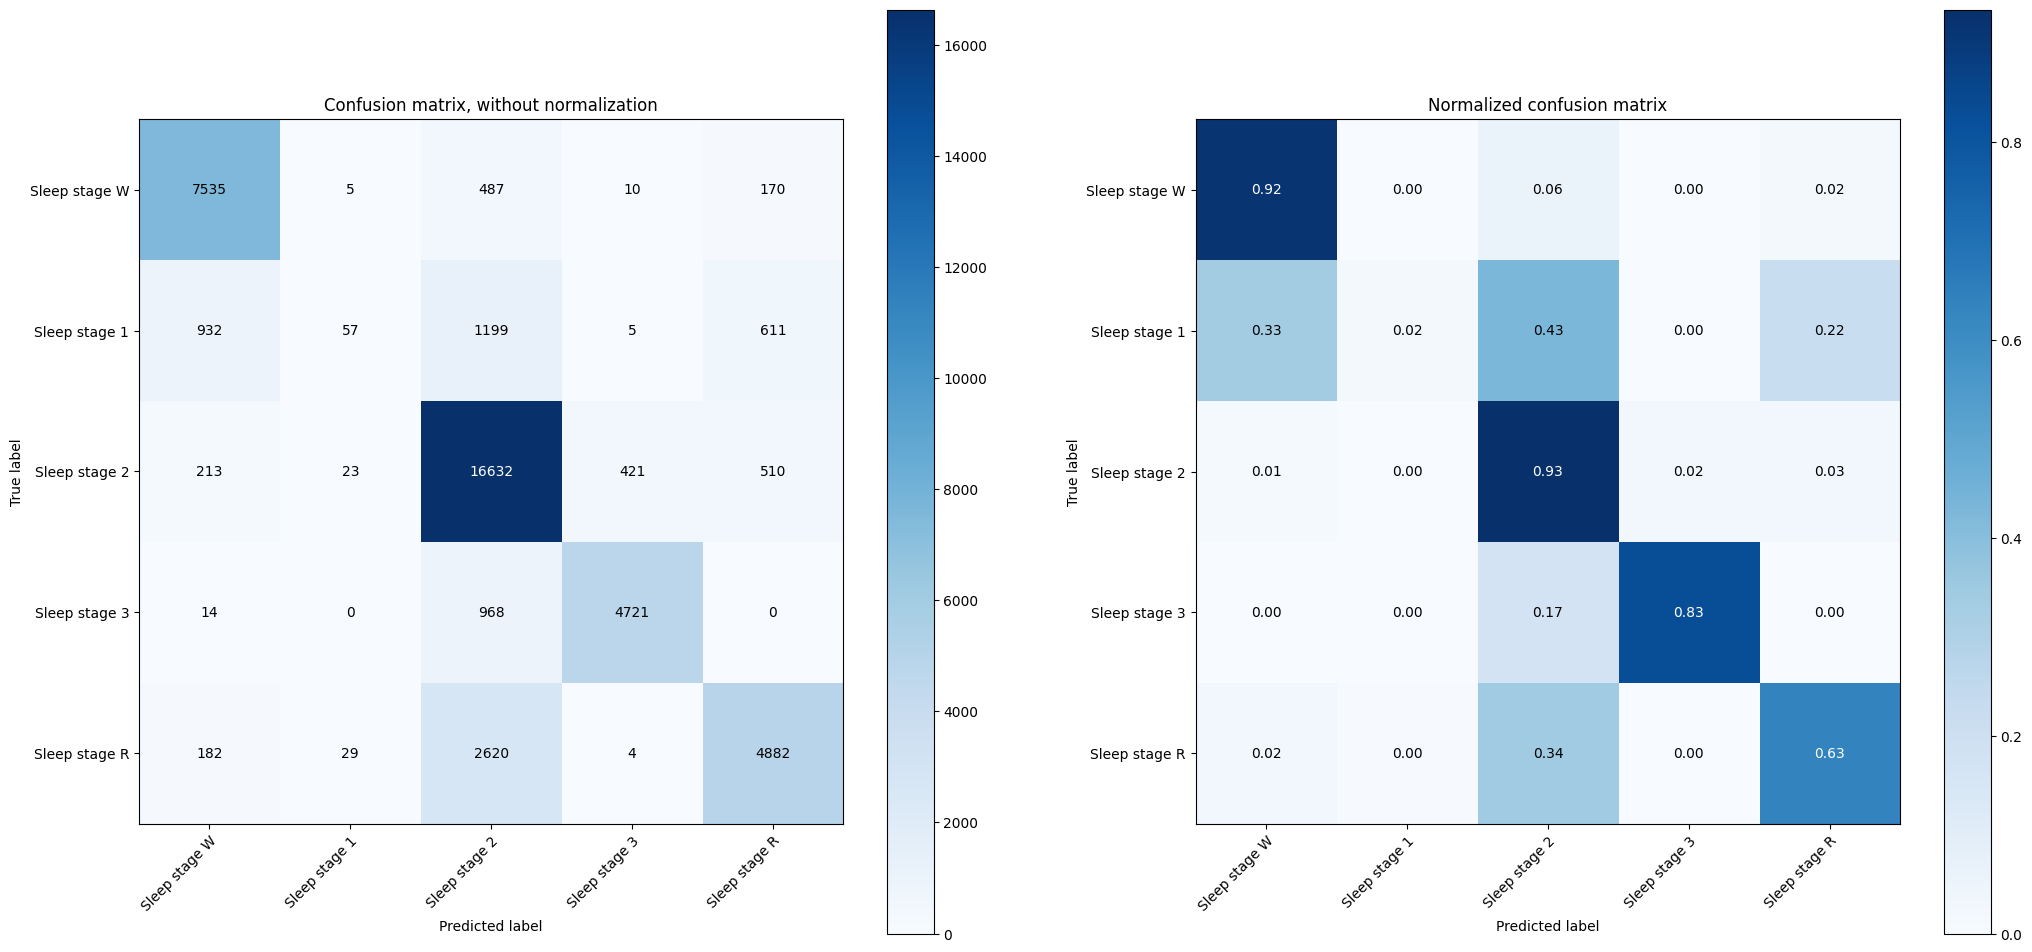

In [111]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=df_feats_trimmed_paper["label"], classes=classes, normalize=True, ax=ax)

    Sleep stage W (wake) is predicted quite accurately, with 92% correct.
    Sleep stages 1 and 2 are reasonably well predicted, with 33% and 93% accuracy respectively. However, stage 1 is often misclassified as stage W or 2.
    Sleep stages 3 and 4 (deep sleep) are poorly distinguished by the model. Stage 3 is usually misclassified as stage 2, while stage 4 is usually misclassified as REM sleep. This suggests the model struggles to identify the deepest sleep stages.
    REM sleep is often confused with stage 2 sleep, being correctly identified only 63% of the time.

In summary, the model performs decently overall, but struggles especially with the deepest sleep stages 3 and 4. Further work would be needed to improve classification of these stages and REM sleep. The normalized matrix provides a clearer view of the relative strengths and weaknesses across the different sleep stages.

# Evaluation and Conclusion

In this project, several different models for sleep stage classification were tested, including a Simple Linear Model, Grouped 20-Fold Linear Model, CatBoost Model, Grouped 20-Fold CatBoost Model, CNN Model, and Random Forest Model. Each model's performance was evaluated using various metrics such as log loss, precision, recall, f1-score, balanced accuracy (Bal. Acc), kappa, and overall accuracy (Acc).


## Model Evaluation

Best Performing Model:

CatBoost Model and the Grouped 20-Fold CatBoost Model generally exhibited the best performance. With low log loss values (0.361 and 0.367, respectively) and high precision, recall, and f1 scores, these models demonstrate a strong capability in effectively solving the complex problem of sleep stage classification. The high performance of these models can be attributed to CatBoost's ability to handle categorical features efficiently and the capability of tree-based algorithms to model complex relationships in the dataset.

## Comparison:

Simple Linear Model and Grouped 20-Fold Linear Model offer reasonable accuracy and balanced accuracy scores but their log loss values (0.493 and 0.829, respectively) and lower f1 scores indicate they are less successful compared to the CatBoost models.
The CNN Model shows lower performance in terms of f1 macro and balanced accuracy, suggesting that while CNNs are powerful for working with raw data, they may require more customization or parameter tuning for specific time series classification tasks.
The Random Forest Model, while offering reasonable overall accuracy, performs lower in terms of log loss, f1 macro, and balanced accuracy compared to the other models. Notably, its very low recall score for sleep stage 1 indicates difficulty in accurately recognizing this class.

## Conclusion:

The findings from this project point towards the CatBoost Model as the most suitable choice for sleep stage classification. The low log loss and high overall accuracy indicate that this model effectively captures the complexities and relationships in the dataset. While other models, such as the Simple Linear Model and CNN, may be useful in certain contexts, they do not perform as strongly as CatBoost. Model selection and optimization should therefore be carefully considered according to the specific requirements of the project, as this can vary depending on the nature of the dataset and the complexity of the model.